In [ ]:
#Import packages
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import cohen_kappa_score

In [42]:
#Read in data
w_basket_data = pd.read_csv('W_Basket_CMJ.csv')
w_basket_df= pd.DataFrame(w_basket_data)
w_basket_df.dropna()

#Printing the first 5 rows
print(w_basket_df.head())

                 TestId        Date      Time                  Name  Segment  \
0  Xj5YxalUvL4V3dKlEjVl  03/19/2025  14:14:29  5E9krELhCQ7yLvDGYsGo      NaN   
1  yVFT5nJ91FhYkFRHC0Z8  03/19/2025  14:13:00  5E9krELhCQ7yLvDGYsGo      NaN   
2  2UV2hDfm5NDmkuCjVsbl  03/11/2025  10:38:38  5E9krELhCQ7yLvDGYsGo      NaN   
3  uU2nvcJ74jje5Xj5beXP  03/11/2025  10:37:50  5E9krELhCQ7yLvDGYsGo      NaN   
4  AYm2iNAtPB6C09QOz6Qb  03/11/2025  10:36:13  5E9krELhCQ7yLvDGYsGo      NaN   

   Position                  Type  Excluded  Tags  System Weight  ...  \
0       NaN  Countermovement Jump       NaN   NaN        656.367  ...   
1       NaN  Countermovement Jump       NaN   NaN        657.101  ...   
2       NaN  Countermovement Jump       NaN   NaN        650.532  ...   
3       NaN  Countermovement Jump       NaN   NaN        650.637  ...   
4       NaN  Countermovement Jump       NaN   NaN        650.531  ...   

   Right Avg. Landing Force  L|R Landing Impulse Index     RSI    mRSI  \
0     

In [43]:
#Creating a new dataset with filtered metrics
metric_df= pd.DataFrame(w_basket_df[['TestId','Date', 'Time', 'Name', 'Jump Height', 'Avg. Braking Force', 'Avg. Propulsive Power',
                       'Time To Takeoff','Left Avg. Braking Force', 'Right Avg. Braking Force', 'L|R Avg. Braking Force', 'Peak Propulsive Power']])
print(metric_df.head())

                 TestId        Date      Time                  Name  \
0  Xj5YxalUvL4V3dKlEjVl  03/19/2025  14:14:29  5E9krELhCQ7yLvDGYsGo   
1  yVFT5nJ91FhYkFRHC0Z8  03/19/2025  14:13:00  5E9krELhCQ7yLvDGYsGo   
2  2UV2hDfm5NDmkuCjVsbl  03/11/2025  10:38:38  5E9krELhCQ7yLvDGYsGo   
3  uU2nvcJ74jje5Xj5beXP  03/11/2025  10:37:50  5E9krELhCQ7yLvDGYsGo   
4  AYm2iNAtPB6C09QOz6Qb  03/11/2025  10:36:13  5E9krELhCQ7yLvDGYsGo   

   Jump Height  Avg. Braking Force  Avg. Propulsive Power  Time To Takeoff  \
0       0.4163           1385.0155              2363.5456            0.622   
1       0.4044           1398.4769              2307.5014            0.603   
2       0.4003           1359.5469              2252.8850            0.693   
3       0.3627           1371.9685              2139.8421            0.653   
4       0.3967           1335.5441              2280.3264            0.632   

   Left Avg. Braking Force  Right Avg. Braking Force  L|R Avg. Braking Force  \
0                 665.97

In [44]:
#Pulling the month out of the Date column 
metric_df['month'] = pd.DatetimeIndex(metric_df['Date']).month
month_df = metric_df['month']

Athlete Readiness Classification 

In [45]:
#Athlete Readiness Classification based on daily jump height average and overall jump height average
def ready_day_classify(metric_df):
    readiness_day_results = []
    
    #Creating a list of the Athlete_IDs
    all_athletes = metric_df['Name'].unique()

    #Looping through each athlete
    for athlete in all_athletes:
        athlete_data = metric_df[metric_df['Name'] == athlete]
        overall_avg = athlete_data['Jump Height'].mean()

        #Creating a list of the jump test dates 
        all_days = metric_df['Date'].unique() #remove this if i want all values for each day
        
        #Looping through each test date 
        for date in all_days:
            daily_data = athlete_data[athlete_data['Date'] == date]
            daily_avg = daily_data['Jump Height'].mean() #change this for readiness score per day to create new function

            #Defining the percent change formula
            percent_change = abs((daily_avg -overall_avg)/ overall_avg) * 100 #change here too

            #Creating the readiness classification based on the percent change
            if percent_change < 10:
                readiness_score = 5
            elif 10 <= percent_change < 15:
                readiness_score = 4
            elif 15 <= percent_change < 20:
                readiness_score = 3
            elif 20 <= percent_change < 25:
                readiness_score = 2
            else:
                readiness_score = 1

            #Creating a list of the results 
            readiness_day_results.append({
                "Athlete_ID" : athlete,
                "Date" : date,
                "Daily_Avg" : daily_avg,
                "Overall_Avg" : overall_avg, 
                "Percent_Change" : percent_change,
                "Readiness_Score" : readiness_score
            })

    #Turning the results list into a dataframe 
    return pd.DataFrame(readiness_day_results)

readiness_day_df = ready_day_classify(metric_df)
readiness_day_df= readiness_day_df.dropna()


In [46]:
readiness_day_df

,Athlete_ID,Date,Daily_Avg,Overall_Avg,Percent_Change,Readiness_Score
0,5E9krELhCQ7yLvDGYsGo,03/19/2025,0.410350,0.371101,10.576487,4
1,5E9krELhCQ7yLvDGYsGo,03/11/2025,0.386567,0.371101,4.167622,5
2,5E9krELhCQ7yLvDGYsGo,03/10/2025,0.377300,0.371101,1.670546,5
3,5E9krELhCQ7yLvDGYsGo,03/05/2025,0.348100,0.371101,6.197941,5
4,5E9krELhCQ7yLvDGYsGo,03/04/2025,0.348567,0.371101,6.072189,5
...,...,...,...,...,...,...
851,w2W0rInDu6nt5ukwWIwL,08/26/2024,0.265867,0.276275,3.767534,5
852,w2W0rInDu6nt5ukwWIwL,08/23/2024,0.270350,0.276275,2.144758,5
853,w2W0rInDu6nt5ukwWIwL,08/22/2024,0.261200,0.276275,5.456670,5
855,w2W0rInDu6nt5ukwWIwL,01/30/2025,0.272550,0.276275,1.348451,5


In [47]:
#Athlete Readiness Classification based on each jump and overall jump height average
def ready_jump_classify(metric_df):
    readiness_jump_results = []
    
    #Creating a list of the Athlete_IDs
    all_athletes = metric_df['Name'].unique()

    #Looping through each athlete
    for athlete in all_athletes:
        athlete_data = metric_df[metric_df['Name'] == athlete]
        overall_avg = athlete_data['Jump Height'].mean()
        
        # Looping through each jump individually
        for jumps in range(len(athlete_data)):  
            jump = athlete_data.iloc[jumps][ 'Jump Height']  
            date = athlete_data.iloc[jumps]['Date']
            test_id = athlete_data.iloc[jumps]['TestId']

            #Defining the percent change formula
            percent_change = abs((jump -overall_avg)/ overall_avg) * 100 #change here too

            #Creating the readiness classification based on the percent change
            if percent_change < 10:
                readiness_score = 5
            elif 10 <= percent_change < 15:
                readiness_score = 4
            elif 15 <= percent_change < 20:
                readiness_score = 3
            elif 20 <= percent_change < 25:
                readiness_score = 2
            else:
                readiness_score = 1

            #Creating a list of the results 
            readiness_jump_results.append({
                "Athlete_ID" : athlete,
                "TestID" : test_id,
                "Date" : date,
                "Jump" : jump,
                "Overall_Avg" : overall_avg, 
                "Percent_Change" : percent_change,
                "Readiness_Percent_Score" : readiness_score
            })

    #Turning the results list into a dataframe 
    return pd.DataFrame(readiness_jump_results)

readiness_jump_df = ready_jump_classify(metric_df)
readiness_jump_df= readiness_jump_df.dropna()


In [48]:
#Creating a new dataframe with all the metrics and the readiness scores per jump 
athlete_df = pd.concat([metric_df, readiness_jump_df.drop(['Athlete_ID', 'TestID', 'Date', 'Jump'], axis=1)], axis=1)

In [49]:
#Athlete Readiness Classification Based on Quintiles 
jump_height_array = athlete_df['Jump Height'].values

q1 = np.percentile(athlete_df['Jump Height'].values, 20)
q2 = np.percentile(athlete_df['Jump Height'].values, 40)
q3 = np.percentile(athlete_df['Jump Height'].values, 60)
q4 = np.percentile(athlete_df['Jump Height'].values, 80)

quint_ready = []
for i, jump in enumerate(jump_height_array):
    if jump < q1:
        quint_ready.append(1)
    elif jump < q2:
        quint_ready.append(2)
    elif jump < q3:
        quint_ready.append(3)
    elif jump < q4:
        quint_ready.append(4)
    else:
        quint_ready.append(5)

athlete_df['Readiness_Quint_Score'] = quint_ready

Text(0, 0.5, 'Frequency')

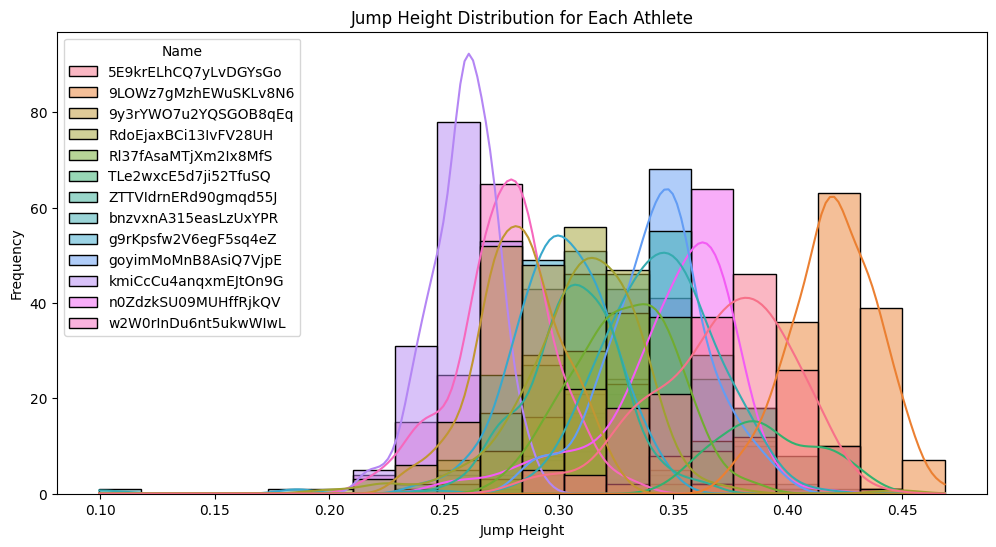

In [50]:
#Jump Height Distribution for Each Athlete 
plt.figure(figsize=(12,6))
sns.histplot(data=athlete_df, x='Jump Height', hue='Name', kde=True, bins=20)
plt.title('Jump Height Distribution for Each Athlete')
plt.xlabel('Jump Height')
plt.ylabel('Frequency')

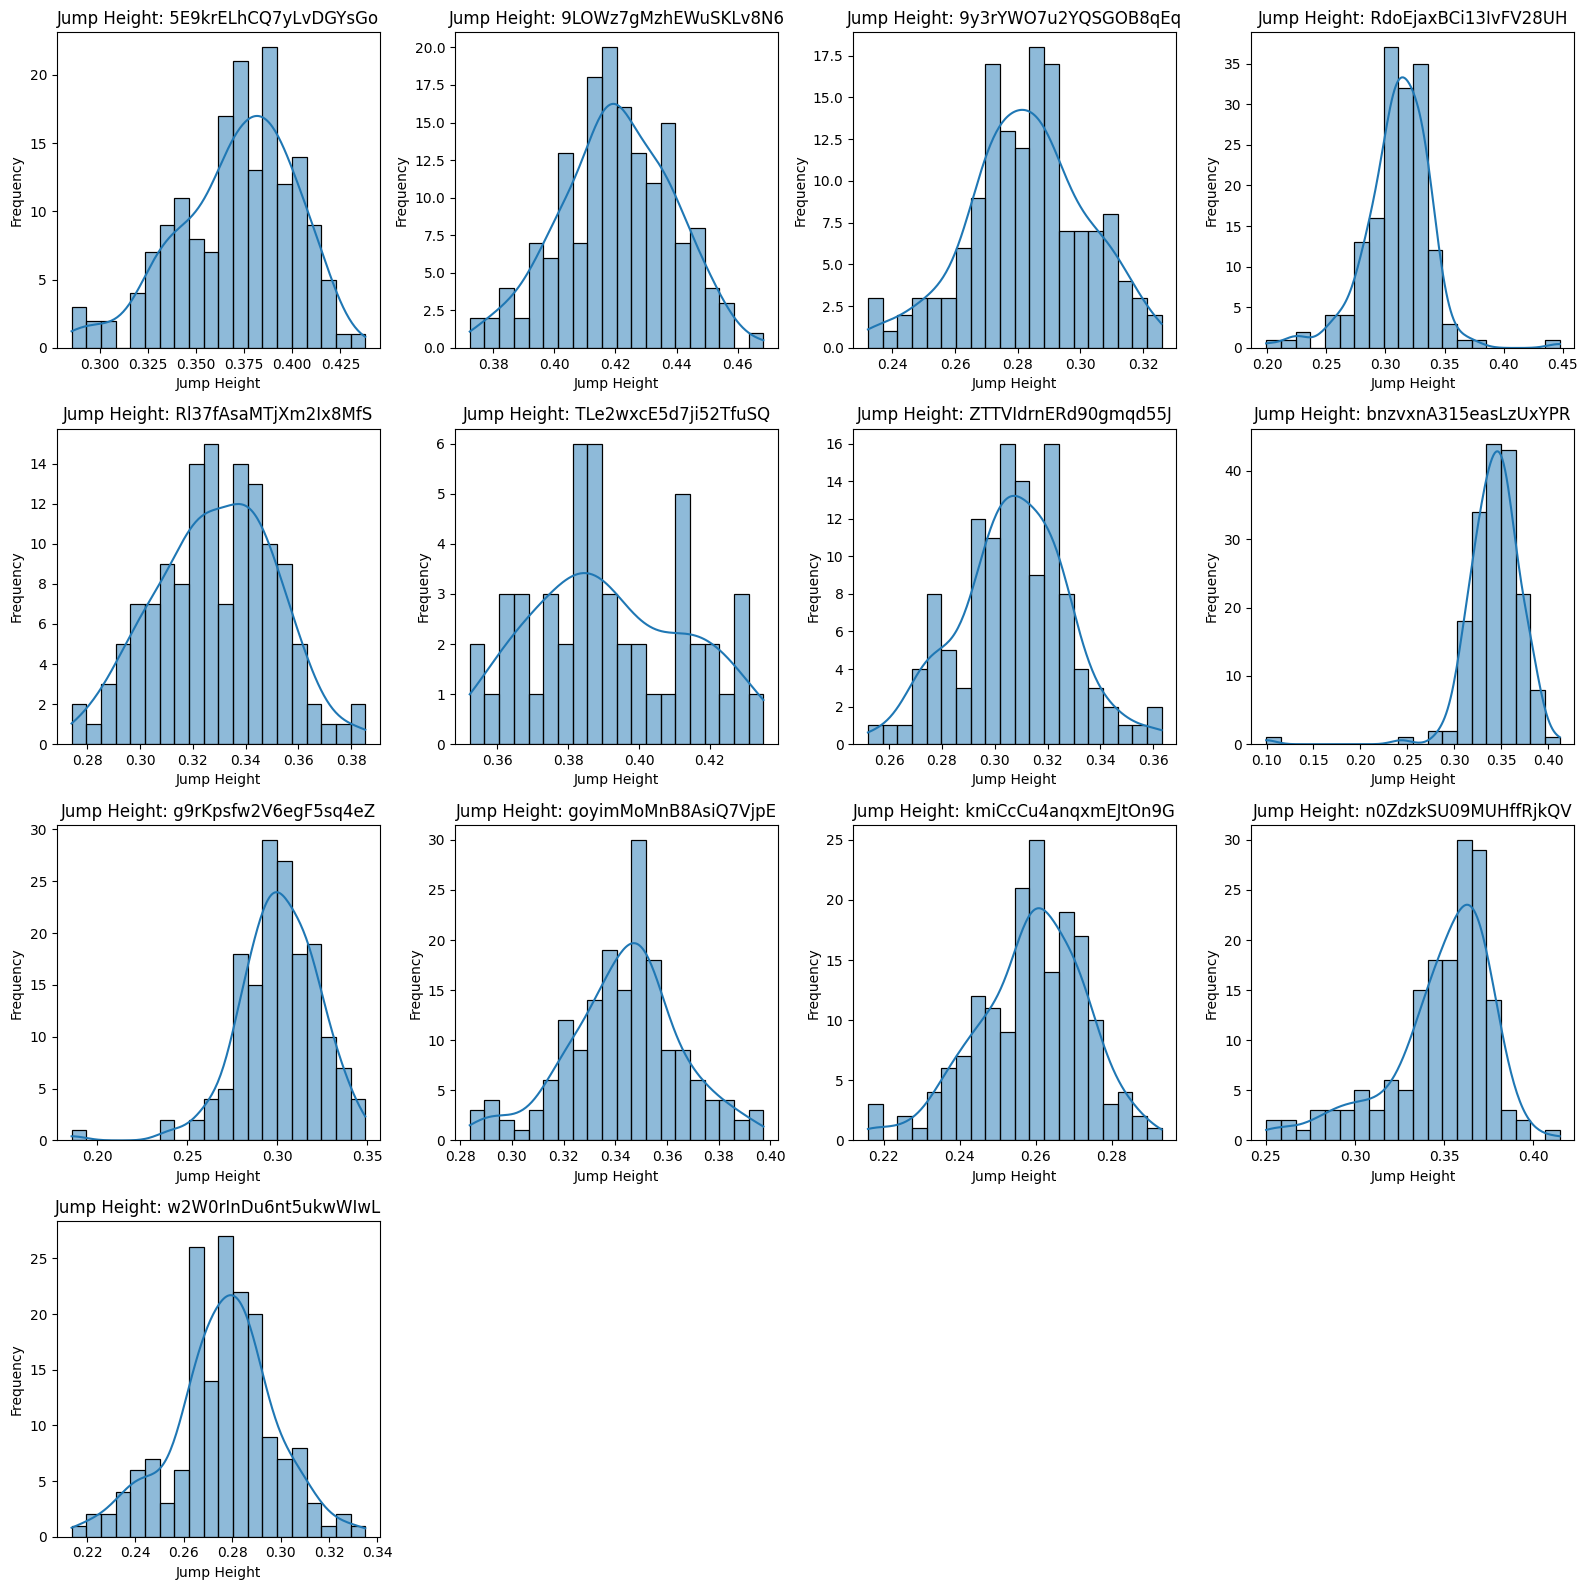

In [51]:
#Jump Height Distribution for Each Athlete 
# Get unique athletes
athletes = athlete_df['Name'].unique()
num_athletes = len(athletes)

# Set up subplots (adjust rows/cols based on the number of athletes)
rows = (num_athletes // 4) + (num_athletes % 4 > 0)  # 4 columns per row
fig, axes = plt.subplots(rows, 4, figsize=(16, rows * 4))
axes = axes.flatten()  # Flatten in case there are extra subplots

# Loop through each athlete and create a histogram
for i, athlete in enumerate(athletes):
    ax = axes[i]
    sns.histplot(data=athlete_df[athlete_df['Name'] == athlete], 
                 x='Jump Height', kde=True, bins=20, ax=ax)
    ax.set_title(f'Jump Height: {athlete}')
    ax.set_xlabel('Jump Height')
    ax.set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

(array([390.,   0., 393.,   0.,   0., 391.,   0., 390.,   0., 393.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

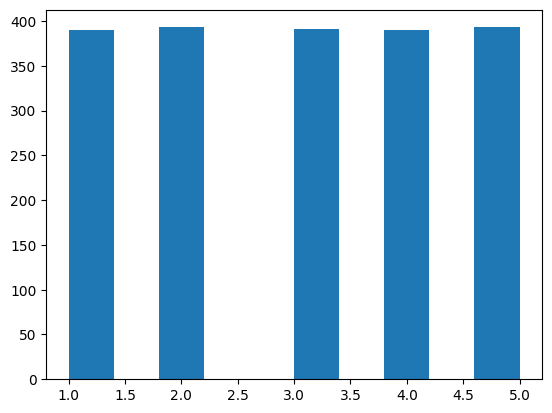

In [52]:
#Visualizing the Readiness_Z_Score Distribution 
plt.hist(athlete_df['Readiness_Quint_Score'])

In [53]:
#Returning the value_counts() of the Readiness_Z_Score
athlete_df['Readiness_Quint_Score'].value_counts()

Readiness_Quint_Score
5    393
2    393
3    391
4    390
1    390
Name: count, dtype: int64

In [54]:
athlete_df

,TestId,Date,Time,Name,Jump Height,Avg. Braking Force,Avg. Propulsive Power,Time To Takeoff,Left Avg. Braking Force,Right Avg. Braking Force,L|R Avg. Braking Force,Peak Propulsive Power,month,Overall_Avg,Percent_Change,Readiness_Percent_Score,Readiness_Quint_Score
0,Xj5YxalUvL4V3dKlEjVl,03/19/2025,14:14:29,5E9krELhCQ7yLvDGYsGo,0.4163,1385.0155,2363.5456,0.622,665.9767,719.0388,-3.8311,4091.0534,3,0.371101,12.179825,4,5
1,yVFT5nJ91FhYkFRHC0Z8,03/19/2025,14:13:00,5E9krELhCQ7yLvDGYsGo,0.4044,1398.4769,2307.5014,0.603,656.0923,742.3846,-6.1704,3905.5816,3,0.371101,8.973148,5,5
2,2UV2hDfm5NDmkuCjVsbl,03/11/2025,10:38:38,5E9krELhCQ7yLvDGYsGo,0.4003,1359.5469,2252.8850,0.693,631.5156,728.0313,-7.0991,3874.6018,3,0.371101,7.868326,5,5
3,uU2nvcJ74jje5Xj5beXP,03/11/2025,10:37:50,5E9krELhCQ7yLvDGYsGo,0.3627,1371.9685,2139.8421,0.653,619.1260,752.8425,-9.7463,3527.0024,3,0.371101,2.263698,5,4
4,AYm2iNAtPB6C09QOz6Qb,03/11/2025,10:36:13,5E9krELhCQ7yLvDGYsGo,0.3967,1335.5441,2280.3264,0.632,643.3456,692.1985,-3.6579,3713.1294,3,0.371101,6.898239,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,GCXEPCTuDFyDsdns7cah,08/23/2024,12:55:51,w2W0rInDu6nt5ukwWIwL,0.2725,1653.5085,2156.8528,0.599,865.7797,787.7288,4.7203,3600.8802,8,0.276275,1.366549,5,1
1953,jOTq4kVz1hdovK7ejyk1,08/23/2024,12:53:20,w2W0rInDu6nt5ukwWIwL,0.2682,1741.2336,2196.0888,0.601,926.3645,814.8692,6.4032,3556.9095,8,0.276275,2.922967,5,1
1954,zxFP12CyxoJmYIjbyqLH,08/22/2024,16:43:39,w2W0rInDu6nt5ukwWIwL,0.2675,1837.8941,2529.6503,0.538,955.0118,882.8824,3.9246,4010.4884,8,0.276275,3.176337,5,1
1955,jf3lBXcvjvUYNrNZv2Rg,08/22/2024,16:42:00,w2W0rInDu6nt5ukwWIwL,0.2667,1757.9895,2415.1438,0.571,938.2632,819.7263,6.7428,3851.3013,8,0.276275,3.465903,5,1


Using Linear Discriminate Analysis to Predict Athlete Readiness 

In [55]:
#Initalizing LDA classifier
lda = LDA(store_covariance=True)


#Setting up data to fit classifier
train= (month_df < 9)

jump_height_train = athlete_df.loc[train] 
jump_height_test  = athlete_df.loc[~train]

Y = athlete_df['Readiness_Quint_Score']
Y_train, Y_test = Y.loc[train], Y.loc[~train]


#Creating testing and training data
jump_height_train = jump_height_train[jump_height_train.columns.drop(['TestId', 'Date', 'Time', 'Name', 'Jump Height', 'Percent_Change', 'Overall_Avg', 'Readiness_Percent_Score',
                                                                      'Readiness_Quint_Score'])]
jump_height_test = jump_height_test[jump_height_test.columns.drop(['TestId', 'Date', 'Time', 'Name', 'Jump Height', 'Percent_Change', 'Overall_Avg', 'Readiness_Percent_Score',
                                                                   'Readiness_Quint_Score'])]


#Fitting data to model
lda.fit(jump_height_train, Y_train)


#Predicting based on model
lda_pred = lda.predict(jump_height_test)

In [56]:
lda_pred

array([3, 5, 5, ..., 1, 1, 1], shape=(1160,))

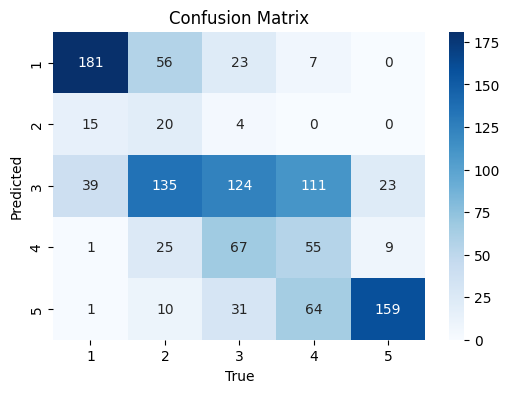

In [57]:
#Confusion Matrix for Z-Score LDA
cm=confusion_matrix(lda_pred, Y_test)

labels = ['1', '2', '3', '4', '5']
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [58]:
#Quadratic Weighted Kappa
kappa_lda = cohen_kappa_score(Y_test, lda_pred, weights="quadratic")
print(kappa_lda)

0.7349549901349801


In [59]:
#Creating the Multi-Class ROC Curve
# Get the predicted probabilities for all classes using the `predict_proba` method
lda_pred_probs = lda.predict_proba(jump_height_test)

# Calculate the multi-class AUC using `roc_auc_score` with 'ovr' (One-vs-Rest)
model_auc = roc_auc_score(Y_test, lda_pred_probs, multi_class='ovr')

print(f'Multi-class AUC: {model_auc}')

Multi-class AUC: 0.8024525278310989


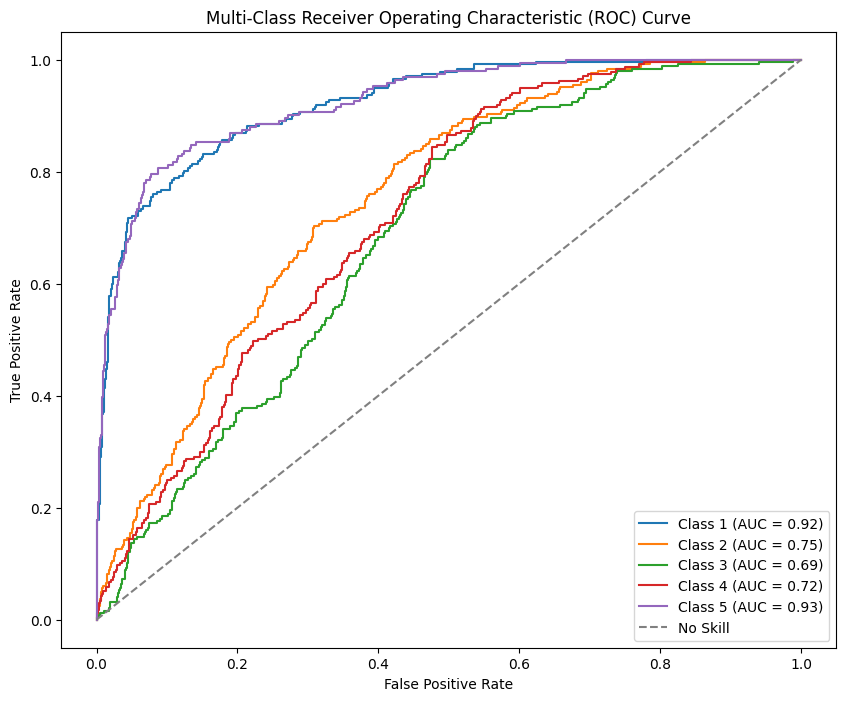

In [60]:
#Plotting the Multi-Class ROC Curve
# Binarize the output labels (One-vs-Rest encoding)
Y_test_binarized = label_binarize(Y_test, classes=np.unique(Y_test))

# Define the number of classes
n_classes = lda_pred_probs.shape[1]

# Create a figure for the plot
plt.figure(figsize=(10, 8))

# Loop through each class and plot the ROC curve
for i in range(n_classes):
    # Compute the ROC curve and AUC for each class
    fpr, tpr, thresholds= roc_curve(Y_test_binarized[:, i], lda_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve for this class
    plt.plot(fpr, tpr, label=f'Class {np.unique(Y_test)[i]} (AUC = {roc_auc:.2f})')

# Plot the "no skill" line (diagonal)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='No Skill')

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')